# Notebook 4.1 - MobileNet v1

### 1. Setup constants

In [1]:
# Constants
data_original_dir = 'data_original'
data_processed_dir = 'data_processed'
split_dirs = ['train', 'test', 'validation']
diagnostic_classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
img_format = 'jpg'

### 2. Imports and notebook setup

In [2]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Printing with markdown
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
# Default imports
import os
import re
import glob
import random
import shutil
from send2trash import send2trash
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import pylab as pl
import cv2

# Tensorflow
import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import top_k_categorical_accuracy
from keras.utils.np_utils import to_categorical
# Sklearn
from sklearn.metrics import confusion_matrix

/Users/lorenzocesconetto/Desktop/ITAU-ANALYTICS/Skin-Cancer/skin_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lorenzocesconetto/Desktop/ITAU-ANALYTICS/Skin-Cancer/skin_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lorenzocesconetto/Desktop/ITAU-ANALYTICS/Skin-Cancer/skin_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)ty

In [4]:
# Magics
%matplotlib inline

In [5]:
data_processed_dir_path = os.path.join('..', data_processed_dir)
data_original_dir_path = os.path.join('..', data_original_dir)

train_path = os.path.join(data_processed_dir_path, split_dirs[0])
test_path = os.path.join(data_processed_dir_path, split_dirs[1])
val_path = os.path.join(data_processed_dir_path, split_dirs[2])

### 3. Create model + Data Augmentation on the fly

#### 3.1 Set version to avoid overwirting previous files

In [6]:
# Set version to avoid overwirting previous files
base_name = 'mobile_net_v'
version = 0
while any([bool(re.match(base_name + str(version), x)) for x in os.listdir('.')]):
    version += 1
print('version', version)

version 2


#### 3.2 Model Constants

In [7]:
# Constants
num_train_samples = len(glob.glob(os.path.join(train_path, '*', '*.' + img_format)))
train_batch_size = 10
image_size = 224
num_epochs = 10

train_steps = np.ceil(num_train_samples / train_batch_size)

#### 3.4 Load train image from disk to memory at run time

In [8]:
# Data flow
datagen = ImageDataGenerator(preprocessing_function = \
                             tensorflow.keras.applications.mobilenet.preprocess_input)

train_flow = datagen.flow_from_directory(train_path,
                                         target_size=(image_size, image_size),
                                         batch_size=train_batch_size)

Found 10324 images belonging to 7 classes.


In [9]:
train_flow.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

#### 3.5 Load validation image to memory

In [10]:
image = cv2.imread('../data_processed/validation/akiec/ISIC_0025539.jpg')
image.shape
new_image = cv2.resize(image, (image_size, image_size))
new_image.shape
n_image = cv2.resize(image[:, 75:525, :], (image_size, image_size))
n_image.shape

(450, 600, 3)

(224, 224, 3)

(224, 224, 3)

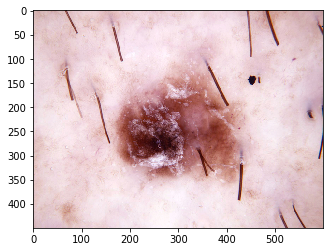

In [11]:
_ = plt.imshow(image[:, :, [2, 1, 0]])

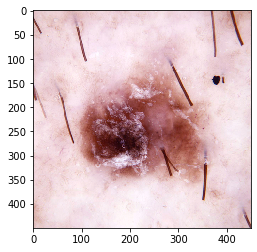

In [12]:
_ = plt.imshow(image[:, 75:525, [2, 1, 0]])

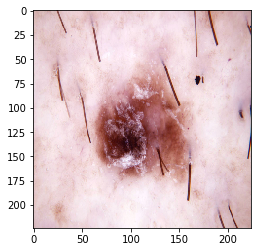

In [13]:
_ = plt.imshow(new_image[:, :, [2, 1, 0]])

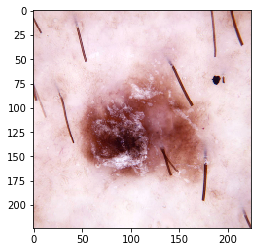

In [14]:
_ = plt.imshow(n_image[:, :, [2, 1, 0]])

In [15]:
X_val = []
y_val = []

for cls in diagnostic_classes:
    counter = 0
    for img in glob.glob(os.path.join(val_path, cls, '*.' + img_format)):
        counter += 1
        X_val.append(tensorflow.keras.applications.mobilenet.preprocess_input(\
                                                        cv2.resize(cv2.imread(img), (image_size, image_size))))
    y_val = y_val + [train_flow.class_indices[cls]] * counter

X_val = np.array(X_val)
y_val = to_categorical(np.array(y_val).reshape(-1, 1))

In [16]:
X_val.shape
y_val.shape

(1494, 224, 224, 3)

(1494, 7)

#### 3.3 Transfer Learning MobileNet

In [17]:
# Load MobileNet
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

mobile.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288    

In [17]:
# Set architecture
x = mobile.layers[-6].output

x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

# Leave only the last 11 layers trainable.
for layer in model.layers[:-9]:
    layer.trainable = False

W0825 00:45:23.991473 4436194752 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [18]:
# Define Top2 Accuracy
def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

#### 3.6 Train Model

In [19]:
checkpoint = ModelCheckpoint(base_name + str(version) + '_{val_acc:.2f}.h5', monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=2,
                                   verbose=1, mode='max', min_lr=0.0001, cooldown=2)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_flow, 
                              steps_per_epoch=train_steps,
                              validation_data=(X_val, y_val),
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/10
1032/1033 [============================>.] - ETA: 0s - loss: 1.0827 - acc: 0.6630
Epoch 00001: val_acc improved from -inf to 0.67871, saving model to mobile_net_v1_0.68.h5
1033/1033 [==============================] - 248s 240ms/step - loss: 1.0828 - acc: 0.6628 - val_loss: 2.0965 - val_acc: 0.6787
Epoch 2/10
1032/1033 [============================>.] - ETA: 0s - loss: 0.7610 - acc: 0.7373
Epoch 00002: val_acc improved from 0.67871 to 0.69478, saving model to mobile_net_v1_0.69.h5
1033/1033 [==============================] - 250s 242ms/step - loss: 0.7607 - acc: 0.7373 - val_loss: 1.4868 - val_acc: 0.6948
Epoch 3/10
1032/1033 [============================>.] - ETA: 0s - loss: 0.6575 - acc: 0.7696
Epoch 00003: val_acc improved from 0.69478 to 0.70683, saving model to mobile_net_v1_0.71.h5
1033/1033 [==============================] - 256s 248ms/step - loss: 0.6573 - acc: 0.7697 - val_loss: 1.8431 - val_acc: 0.7068
Epoch 4/10
1032/1033 [============================>.] - ETA: 0s 

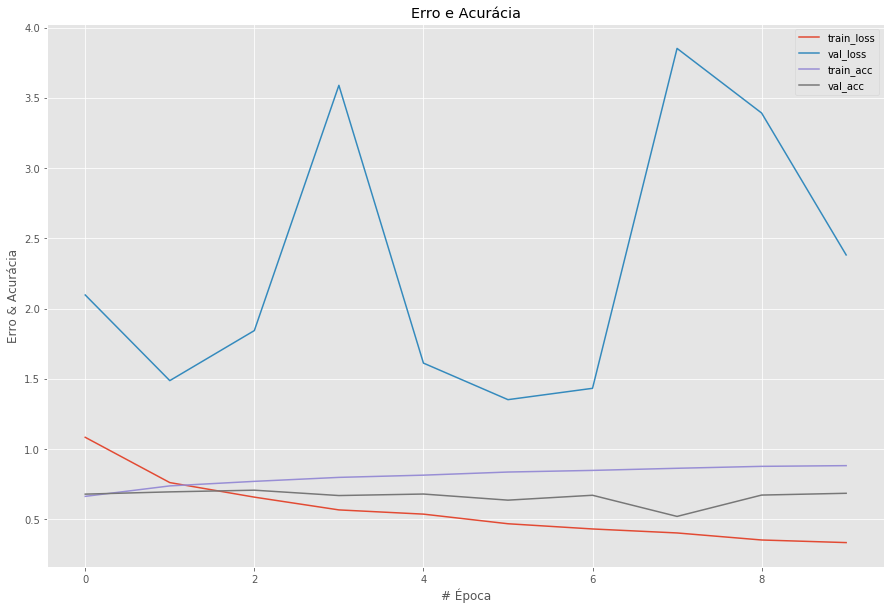

In [23]:
plt.style.use("ggplot")
_ = plt.figure(figsize=(15, 10))
_ = plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
_ = plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
_ = plt.plot(np.arange(0, num_epochs), history.history["acc"], label="train_acc")
_ = plt.plot(np.arange(0, num_epochs), history.history["val_acc"], label="val_acc")
_ = plt.title("Erro e Acurácia")
_ = plt.xlabel("# Época")
_ = plt.ylabel("Erro & Acurácia")
_ = plt.legend(loc="upper right")


plt.savefig(base_name + str(version) + '.png')

### 3.7 Confusion matrix

In [ ]:
labels = [str(i % 10) for i in range(10)]
cm = confusion_matrix(y_true=true_class.astype(str), y_pred=predicted_class.astype(str), labels=labels)

df_cm = pd.DataFrame(cm, index=labels)
_ = plt.figure(figsize = (10,7))
_ = sn.heatmap(df_cm, annot=True)

# plt.savefig('imgs/ELM_confusion_matrix.png')